## Installing Packages

In [92]:
# !pip install q tensorflow==2.8.2
# !pip install q keras==2.8.0
# !pip install q numpy==1.21.6
# !pip install q matplotlib==3.2.2
# !pip install q pandas==1.3.5
# !pip install q ipywidgets==7.7.0
# !pip install q scipy==1.4.1
# !pip install q sklearn==1.0.2

## Import necessary packages

In [3]:
import tensorflow as tf

In [89]:
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense
from keras.layers.embeddings import Embedding

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
import matplotlib.pyplot as plt

In [8]:
from ipywidgets import FileUpload

In [9]:
import io

In [10]:
import random

## Obtaining data

This enables an upload button in the jupyter notebook, through which you can upload the file

In [11]:
uploader= FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [13]:
file = list(uploader.value.values())[0]
content = file['content']
content = io.StringIO(content.decode('utf-8'))
df = pd.read_csv(content, parse_dates=True)

Alternatively, if the csv file is located in same directory as your jupyter notebook, you can load the file using the below commented code

In [14]:
# df = pd.read_csv('INR=X.csv')

## Data Cleaning

Finding the no. of missing rows

In [15]:
expected_no_of_rows  = 18*365

In [17]:
actual_no_of_rows = len(df)

In [18]:
missing_rows = expected_no_of_rows - actual_no_of_rows

In [19]:
missing_rows

1746

We neglect this missing rows

Sampling a roughly 0.1% of dataset

In [21]:
df.sample(frac = 0.001)

,Date,Open,High,Low,Close,Adj Close,Volume
2343,2012-11-22,54.950001,55.292999,54.950001,55.108002,55.108002,0.0
835,2007-02-12,43.971001,44.187500,43.939999,44.074001,44.074001,0.0
2062,2011-10-26,49.498001,49.498001,49.340000,49.410000,49.410000,0.0
3266,2016-06-07,66.801003,66.919998,66.559998,66.801003,66.801003,0.0
336,2005-03-15,43.452999,43.513000,43.430000,43.480000,43.480000,0.0


Checking for null values

In [22]:
df.isna().sum()

Date          0
Open         32
High         32
Low          32
Close        32
Adj Close    32
Volume       32
dtype: int64

Dropping rows containing null values

In [23]:
df.dropna(inplace = True)

## Making a baseline Linear Model

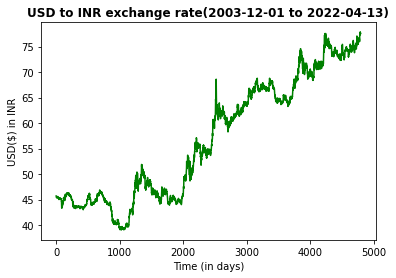

In [24]:
plt.xlabel('Time (in days)')                                                                            #Set label for x-axis 
plt.ylabel('USD($) in INR')                                                                             #Set label for y-axis
plt.plot([i for i in range(len(df['Close']))], df['Close'], color = 'g')                                #Plot  the exchange rate vs time graph
plt.title(f'USD to INR exchange rate({df["Date"][0]} to {df["Date"][len(df)]})', fontweight = 'bold')   #Set title for the plot
plt.show()                                                                                              #Show the plot

In [25]:
from scipy.stats import linregress

Making linear model for the exchange rate

In [26]:
linear_model = linregress(df.index, df['Close'])

Below parameters define our linear model

In [27]:
slope, intercept, rvalue, pvalue, stderr = linear_model

Plotting the predicted values and actual values for comparision

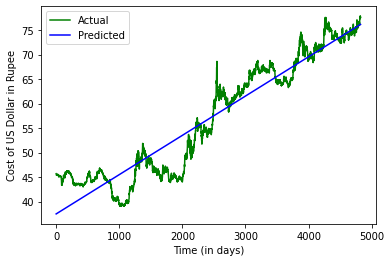

In [28]:
plt.xlabel('Time (in days)')                                                                            #Set label for x-axis 
plt.ylabel('Cost of US Dollar in Rupee')                                                                #Set label for y-axis
plt.plot(df.index, df['Close'], label = 'Actual', color = 'g')                                          #Plot the actual exchange rate vs time graph
#slope*df.index + intercept gives the predicted value for the day indicated by df.index
plt.plot(df.index,  slope*df.index + intercept, label = 'Predicted', color = 'b')                       #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                            #Display legend bar
plt.show()                                                                                              #Show the plot

np.absolute(df['Close'] - slope*df.index - intercept) calculates the absolute difference between predicted and actual values. The mean of these differences gives the average error in our predictions

In [29]:
print('Baseline absolute error : ', np.absolute(df['Close'] - slope*df.index - intercept).mean())

Baseline absolute error :  2.972667821651601


## Preparing data for LSTM Model

Splitting the dataset into training and testing sets

In [30]:
train_df = df[:3500]
test_df = df[3500:]

Define a function which splits our data into proper input and output time steps, which can suitably be fed to LSTM model

In [31]:
def split_sequence_LSTM(sequence, input_time_steps, output_time_steps = 1):
    '''
       Function takes a time-series, no. of time steps in input data, and no. of time steps in label data as input
       It returns numpy arrays of LSTM input data and LSTM labels
    '''
    X, y = [], []                                                                               #Initialising the lists which will store the input and output time steps respectively.

    for i in range(len(sequence)):
        if i + input_time_steps + output_time_steps > len(sequence):                            #If no more data is available for output steps, break out of the loop.
            break
        X.append(sequence[i : i + input_time_steps])                                            #Appending a list of values which is an input sequence.
        y.append(sequence[i + input_time_steps : i + input_time_steps + output_time_steps])     #Appending a list of values which is an output sequence.
    
    X = np.array(X)                                                                             #Converting the list of input sequences into 1D np array of sequences, i.e., a 2D np array.
    X = X.reshape(X.shape[0], X.shape[1], 1)                                                    #Broadcasting 2D np array into 3D numpy array. This is only a requirement for LSTM and no change occurs to size of sequences of no. of sequences.

    y = np.array(y)                                                                             #Converting the list of output sequences into 1D np array of sequences, i.e., a 2D np array.
    
    return X, y

Converting pandas Dataframe column to numpy array, since keras models accept only numpy arrays, for the current version.

In [32]:
train = train_df['Close'].to_numpy()

Converting training values to between -1 and 1

In [33]:
train = (train.mean() - train)/train.mean()

Spliiting the training dataset into input and target datasets

In [34]:
X_train, y_train = split_sequence_LSTM(train, 175)

Verifying the shape of input and target datasets

In [35]:
X_train.shape, y_train.shape

((3325, 175, 1), (3325, 1))

## Single-step LSTM model -- Forecasting for a day

In [36]:
single_step_model = Sequential()                                                                               #Defining the model as Sequential
# single_step_model.add(Embedding(3325, 128, input_length = 175, ))
# single_step_model.add(LeakyReLU(0.2))
# single_step_model.add(LSTM(128, activation = 'relu', input_shape = (175, 1)))
# single_step_model.add(LSTM(32, return_sequences = True))
# single_step_model.add(LSTM(64, return_sequences = False))
single_step_model.add(LSTM(50, activation='relu', input_shape=(175, 1)))                                       #Adding LSTM layer with 50 dimensions
single_step_model.add(Dense(1))                                                                                #Adding a Dense layer, which gives out one value(i.e., the prediction)
single_step_model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'mean_squared_error')     #Compiling the model
single_step_model.fit(X_train, y_train, epochs = 3)                                                            #Training the model on our input and target datasets

Epoch 1/3
104/104 [==============================] - 13s 91ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 2/3
104/104 [==============================] - 9s 84ms/step - loss: 8.5439e-05 - mean_squared_error: 8.5439e-05
Epoch 3/3
104/104 [==============================] - 9s 86ms/step - loss: 8.2270e-05 - mean_squared_error: 8.2270e-05


Predicting values on the training input dataset. 

In [37]:
preds = single_step_model.predict(X_train)

Comparing the predictions on training data and targets of training data using a plot

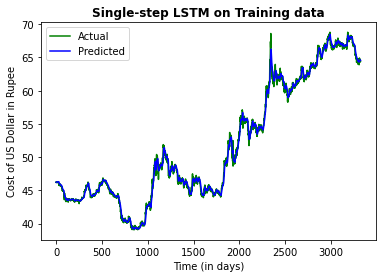

In [38]:
plt.xlabel('Time (in days)')                                                                                                         #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                             #Set label for y-axis
#-(y_train*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train
plt.plot([i for i in range(3325)], -(y_train*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')    #Plot the actual exchange rate vs time graph
#-(preds*train_df['Close'].mean()) + train_df['Close'].mean() gives the predicted value in range of y_train
plt.plot([i for i in range(3325)], -(preds*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')   #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                                                         #Display legend box
plt.title('Single-step LSTM on Training data', fontweight = 'bold')                                                                  #Set title for the plot
plt.show()                                                                                                                           #Show the plot

Converting pandas Dataframe column to numpy array, since keras models accept only numpy arrays, for the current version.

In [39]:
test = test_df['Close'].to_numpy()

Converting testing values to between -1 and 1

In [40]:
test = (test.mean() - test)/test.mean()

Spliiting the testing dataset into input and target datasets

In [41]:
X_test, y_test = split_sequence_LSTM(test, 175)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Predicting values on the testing input dataset.

In [42]:
test_preds = single_step_model.predict(X_test)

Comparing the predictions on testing data and targets in testing data using a plot

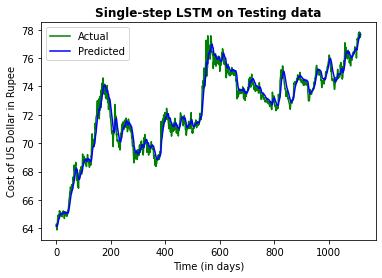

In [43]:
plt.xlabel('Time (in days)')                                                                                                                          #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                              #Set label for y-axis
#-(y_test*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of y_test                
plt.plot([i for i in range(len(df)-3500 - 175)], -(y_test*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')          #Plot the actual exchange rate vs time graph
#-(preds*test_df['Close'].mean()) + test_df['Close'].mean() gives the predicted value in range of y_test
plt.plot([i for i in range(len(df)-3500 - 175)], -(test_preds*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')   #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                                                                          #Display legend box
plt.title('Single-step LSTM on Testing data', fontweight = 'bold')                                                                                    #Set title for the plot
plt.show()                                                                                                                                            #Show the plot

Mean absolute error on training dataset

In [ ]:
np.absolute(preds - y_train).mean()

Mean absolute error on testing dataset

In [44]:
np.absolute(test_preds - y_test).mean()

0.005103606796807328


## Multi-step LSTM Model -- Forecasting for a week

Spliiting the training dataset into input and target datasets

In [45]:
X_train, y_train = split_sequence_LSTM(train, 250, 7)

Verify the shape of input and target datasets

In [46]:
X_train.shape, y_train.shape

((3244, 250, 1), (3244, 7))

Define a custom optimizer function with learning_rate = 1.0 (not 0.1), epsilon = 0.1 (not 1e-8), clipnorm = 1.0 (not None),

In [47]:
opt = tf.keras.optimizers.Adam(learning_rate = 1.0, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0, clipnorm = 1.0)

Making a multi-step LSTM model.

In [48]:
multi_step_model = Sequential()                                                                               #Defining the model as Sequential
multi_step_model.add(LSTM(128, activation='relu', input_shape=(250, 1)))                                      #Adding LSTM layer with 128 dimensions
multi_step_model.add(Dense(7))                                                                                #Adding a Dense layer, which gives out 7 values(the predictions)
multi_step_model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = 'mean_squared_error')        #Compiling the model
multi_step_model.fit(X_train, y_train, epochs = 3)                                                            #Training the model on our input and target datasets

Epoch 1/3
102/102 [==============================] - 28s 258ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/3
102/102 [==============================] - 32s 312ms/step - loss: 1.9531e-04 - mean_squared_error: 1.9531e-04
Epoch 3/3
102/102 [==============================] - 31s 301ms/step - loss: 2.1063e-04 - mean_squared_error: 2.1063e-04


Predicting values on the training input dataset.

In [49]:
preds = multi_step_model.predict(X_train)

Verifying the shape of prediction dataset

In [50]:
preds.shape

(3244, 7)

Comparing the predictions on training data and targets in training data using a plot for a week

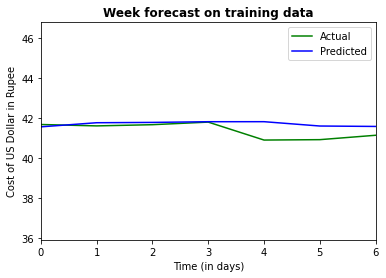

In [51]:
random_number = random.randint(0, preds.shape[0])                                                                                                     #Generating a random number from the total range
plt.xlabel('Time (in days)')                                                                                                                          #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                              #Set label for y-axis
#-(y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train 
plt.plot([i for i in range(7)], (y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')          #Plot the actual exchange rate vs time graph
#-(preds[random_number]*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train 
plt.plot([i for i in range(7)], (preds[random_number]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')         #Plot the predicted exchange rate vs time graph
plt.xlim([0,6])                                                                                                                                       #Set x limit to plot
plt.ylim([((y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean()).min() - 5, ((y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean()).max() + 5])   #Set y limit to plot
plt.legend()                                                                                                                                          #Display legend box
plt.title('Week forecast on training data', fontweight = 'bold')                                                                                      #Set title for the plot
plt.show()                                                                                                                                            #Show the plot

Now, we select sequences from predicted data such that each week is covered fully and no data point is redundant

In [52]:
whole_preds = np.array([preds[i] for i in range(0, preds.shape[0], 7)], dtype = 'object')

Converting the week sequences into a flat array

In [53]:
whole_preds = whole_preds.reshape(whole_preds.shape[0]*7)

Some of the data points are missed in the process, which is reflected by difference in sizes of the datasets

In [54]:
len(whole_preds), len(train)

(3248, 3500)

Comparing the predictions on training data and targets in training data using a plot

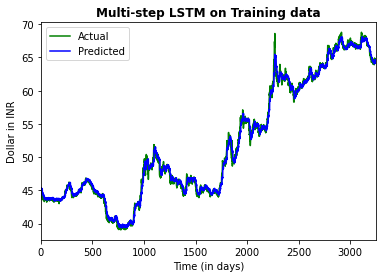

In [56]:
plt.xlabel('Time (in days)')                                                                                                                                              #Set label for x-axis
plt.ylabel('Dollar in INR')                                                                                                                                               #Set label for y-axis
#(-1)*(train*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of train_df['Close']
plt.plot([i for i in range(len(whole_preds))], ((-1)*train[250:len(whole_preds) + 250]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')   #Plot the actual exchange rate vs time graph
#(-1)*(whole_preds*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of train_df['Close']
plt.plot([i for i in range(len(whole_preds))], ((-1)*whole_preds*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')                  #Plot the predicted exchange rate vs time graph
plt.xlim([0, len(whole_preds)])                                                                                                                                           #Set x limit to plot
plt.legend()                                                                                                                                                              #Display legend box       
plt.title('Multi-step LSTM on Training data', fontweight = 'bold')                                                                                                        #Set title for the plot
plt.show()                                                                                                                                                                #Show the plot

Converting pandas Dataframe column to numpy array, since keras models accept only numpy arrays, for the current version.

In [58]:
test = test_df['Close'].to_numpy()

Converting testing values to between -1 and 1

In [59]:
test = (test.mean() - test)/test.mean()

Spliiting the training dataset into input and target datasets

In [60]:
X_test, y_test = split_sequence_LSTM(test, 250, 7)

Verify the shape of input and target datasets

In [61]:
X_test.shape, y_test.shape

((1036, 250, 1), (1036, 7))

Predicting values on the testing input dataset.

In [62]:
test_preds = multi_step_model.predict(X_test)

Verifying the shape of prediction dataset

In [63]:
test_preds.shape

(1036, 7)

Comparing the predictions on training data and targets in training data using a plot for a week

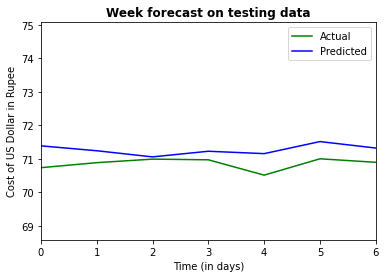

In [64]:
random_number = random.randint(0, test_preds.shape[0])                                                                                                     #Generating a random number from the total range
plt.xlabel('Time (in days)')                                                                                                                               #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                                   #Set label for y-axis
#(-1)*(y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(7)], (-1)*(y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')             #Plot the actual exchange rate vs time graph
#(-1)*(test_preds[random_number-1]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(7)], (-1)*(test_preds[random_number-1]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')    #Plot the predicted exchange rate vs time graph
plt.xlim([0,6])                                                                                                                                            #Set x limit to plot
plt.ylim([((y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean()).min() - 3, ((y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean()).max() + 3])   #Set y limit to plot
plt.legend()                                                                                                                                               #Display legend box
plt.title('Week forecast on testing data', fontweight = 'bold')                                                                                            #Set title for the plot
plt.show()                                                                                                                                                 #Show the plot

Now, we select sequences from predicted data such that each week is covered fully and no data point is redundant

In [65]:
whole_test_preds = np.array([test_preds[i] for i in range(0, test_preds.shape[0], 7)], dtype = 'object')

Converting the week sequences into a flat array

In [66]:
whole_test_preds = whole_test_preds.reshape(whole_test_preds.shape[0]*7)

Some of the data points are missed in the process, which is reflected by difference in sizes of the datasets

In [67]:
whole_test_preds.shape, test.shape

((1036,), (1292,))

Comparing the predictions on training data and targets in training data using a plot

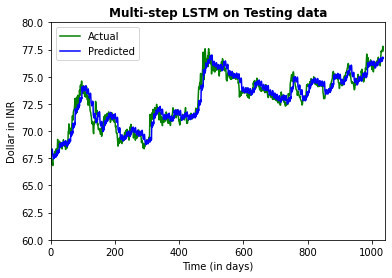

In [68]:
plt.xlabel('Time (in days)')                                                                                                                                             #Set label for x-axis
plt.ylabel('Dollar in INR')                                                                                                                                              #Set label for y-axis
#((-1)*test[250:len(whole_test_preds)]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(len(whole_test_preds))], ((-1)*test[250:len(whole_test_preds) + 250]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')     #Plot the actual exchange rate vs time graph
#((-1)*whole_test_preds*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(len(whole_test_preds))], ((-1)*whole_test_preds*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')         #Plot the predicted exchange rate vs time graph
plt.xlim([0, len(test) - 250])                                                                                                                                           #Set x limit to plot
plt.ylim([60, 80])                                                                                                                                                       #Set y limit to plot
plt.legend()                                                                                                                                                             #Display legend box
plt.title('Multi-step LSTM on Testing data', fontweight = 'bold')                                                                                                        #Set title for the plot
plt.show()                                                                                                                                                               #Show the plot

In [69]:
from sklearn.metrics import r2_score

Mean absolute error of predictions from actual value on training dataset

In [70]:
np.absolute((whole_preds - train[250 : len(train) - 2])*train_df['Close'].mean()).mean()

0.4621605180307306

r2 score of predictions on training dataset

In [71]:
r2_score(whole_preds, train[250 : len(train) - 2])

0.9945731906054244

Mean absolute error of predictions from actual value on testing dataset

In [72]:
np.absolute((whole_test_preds - test[250:len(test) - 6])*test_df['Close'].mean()).mean()

0.511878818991177

r2 score of predictions on testing dataset

In [73]:
r2_score(whole_test_preds, test[250:len(test) - 6])

0.911413111550993